In [1]:
# Torch imports
import torch
from torchvision.transforms import v2

# File reading
import os
import pickle
from glob import glob

# Utils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# 1. Global Annotations File 

In [19]:
# Annotations structure
file = './datasets/with-augmentations/Room1/Setting1/episode_0001/episode_0001.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)
    display(df.head())

,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,robot_1_rel_pos_y,robot_1_in_fov,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,-1.423542,True,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,-2.282922,True,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,-3.499867,True,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,-4.512129,False,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,-4.921282,False,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [ ]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a global annotations file
ep_dfs = []
for room in range(1, len(glob('./datasets/with-augmentations/*'))+1):
    room_dir = f'./datasets/with-augmentations/Room{room}'

    for setting in range(1, len(glob(f'{room_dir}/*'))+1):
        set_dir = f'{room_dir}/Setting{setting}'
        for ep_dir in sorted(glob(f'{set_dir}/episode_*')):     

            ep = ep_dir.split('/')[-1]
            try:
                with open(f'{ep_dir}/{ep}.pkl', 'rb') as f:
                    df = pickle.load(f)
                    df.insert(0, 'setting', np.ones(df.shape[0], dtype=int) * setting)
                    df.insert(0, 'room', np.ones(df.shape[0], dtype=int) * room)
                    ep_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {ep_dir}/{ep}.pkl')

ep_dfs = pd.concat(ep_dfs)
ep_dfs.index = list(range(0, ep_dfs.shape[0]))

display(ep_dfs.head())

File not found: ./datasets/with-augmentations/Room1/Setting3/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting4/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting5/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting6/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting7/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting8/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting9/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting10/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting1/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting2/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting3/episode_0010/episode_0010.pk

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [21]:
# Save the annotations file (will be used in the torch Dataset object)
if not os.path.exists('./datasets/with-augmentations/annotations.pkl'):
    ep_dfs.to_pickle('./datasets/with-augmentations/annotations.pkl')

# 2. Image Analysis

In [118]:
file = './datasets/with-augmentations/annotations.pkl'
with open(file, 'rb') as f:
    ep_dfs = pickle.load(f)
    display(ep_dfs.head())

print(f"Number of records: {ep_dfs.shape[0]}")

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


Number of records: 19437


In [119]:
# Random sample as anchor
rand_idx = np.random.randint(1, ep_dfs.shape[0] + 1)

anchor_rec = ep_dfs.iloc[rand_idx]
room = anchor_rec['room']
setting = anchor_rec['setting']
ep = anchor_rec['episode']
step = anchor_rec['step']

f"{room}", f"{setting}", f"{ep:04}", f"{step:05}"

('2', '5', '0006', '00037')

In [120]:
anchor_rec

room                                                                 2
setting                                                              5
episode                                                              6
step                                                                37
target_point_x                                                     2.5
target_point_y                                                     0.0
robot_pos_x                                                  -1.162517
robot_pos_y                                                   0.891086
robot_yaw                                                     0.242932
robot_1_rel_pos_x                                              4.98839
robot_1_rel_pos_y                                            -4.033883
robot_1_in_fov                                                    True
robot_2_rel_pos_x                                             2.237396
robot_2_rel_pos_y                                             -3.75191
robot_

In [121]:
# Look for positive examples in either other rooms or settings
pos_df = ep_dfs[(ep_dfs['room'] != anchor_rec['room']) | (ep_dfs['setting'] != anchor_rec['setting'])].copy()
pos_df

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19432,2,10,9,95,2.5,0.0,2.148549,0.440679,-0.448685,3.561599,...,-6.517727,-4.626626,False,1.312819,0.686854,True,"{'scan': [[0.11502454], [0.11180131], [0.10878...",9.0,10.0,11.0
19433,2,10,9,96,2.5,0.0,2.192943,0.418303,-0.487883,3.624322,...,-6.398505,-4.910989,False,1.228000,0.742738,True,"{'scan': [[0.113904215], [0.1104313], [0.10718...",9.0,10.0,11.0
19434,2,10,9,97,2.5,0.0,2.236652,0.394129,-0.525299,3.678385,...,-6.273469,-5.180602,False,1.143597,0.796684,True,"{'scan': [[0.11222798], [0.108507], [0.1050449...",9.0,10.0,11.0
19435,2,10,9,98,2.5,0.0,2.279233,0.368403,-0.563286,3.731676,...,-6.131744,-5.450736,False,1.060822,0.846992,True,"{'scan': [[0.109117076], [0.10516085], [0.1014...",9.0,10.0,11.0


In [122]:
# Look for negative examples in other episodes of the same setting of the room
neg_df = ep_dfs[(ep_dfs['room'] == anchor_rec['room']) & (ep_dfs['setting'] == anchor_rec['setting']) & (ep_dfs['episode'] != anchor_rec['episode'])].copy()
neg_df

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
13756,2,5,1,1,2.5,0.0,-2.498559,0.000117,0.119742,7.081493,...,-2.332820,0.596585,False,3.112556,-3.596984,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13757,2,5,1,2,2.5,0.0,-2.499363,-0.000160,0.320459,6.869615,...,-2.168060,1.048718,False,2.320932,-4.159889,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13758,2,5,1,3,2.5,0.0,-2.495807,0.001569,0.521729,6.378489,...,-1.930222,1.456502,False,1.416757,-4.561074,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13759,2,5,1,4,2.5,0.0,-2.501095,-0.002655,0.763061,5.462859,...,-1.537566,1.877539,False,0.266379,-4.784112,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13760,2,5,1,5,2.5,0.0,-2.495040,0.005204,1.026465,4.084382,...,-1.018578,2.225855,False,-1.027360,-4.696367,False,"{'scan': [[0.72911024], [0.7366151], [0.744531...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14884,2,5,9,104,2.5,0.0,2.022428,0.375886,-0.560943,-8.053968,...,1.596305,-2.197601,False,0.678290,-3.848661,False,"{'scan': [[0.35224375], [0.34008208], [0.32882...",9.0,10.0,11.0
14885,2,5,9,105,2.5,0.0,2.066491,0.347828,-0.573346,-8.141291,...,1.602473,-2.172250,False,0.659055,-3.842925,False,"{'scan': [[0.3489419], [0.3365545], [0.3251047...",9.0,10.0,11.0
14886,2,5,9,106,2.5,0.0,2.110205,0.319144,-0.588767,-8.224782,...,1.614372,-2.135419,True,0.653061,-3.838840,False,"{'scan': [[0.347718], [0.3349099], [0.32309785...",9.0,10.0,11.0
14887,2,5,9,107,2.5,0.0,2.153475,0.290111,-0.592968,-8.308686,...,1.598714,-2.111287,True,0.606131,-3.845512,False,"{'scan': [[0.33922142], [0.32656774], [0.31490...",9.0,10.0,11.0


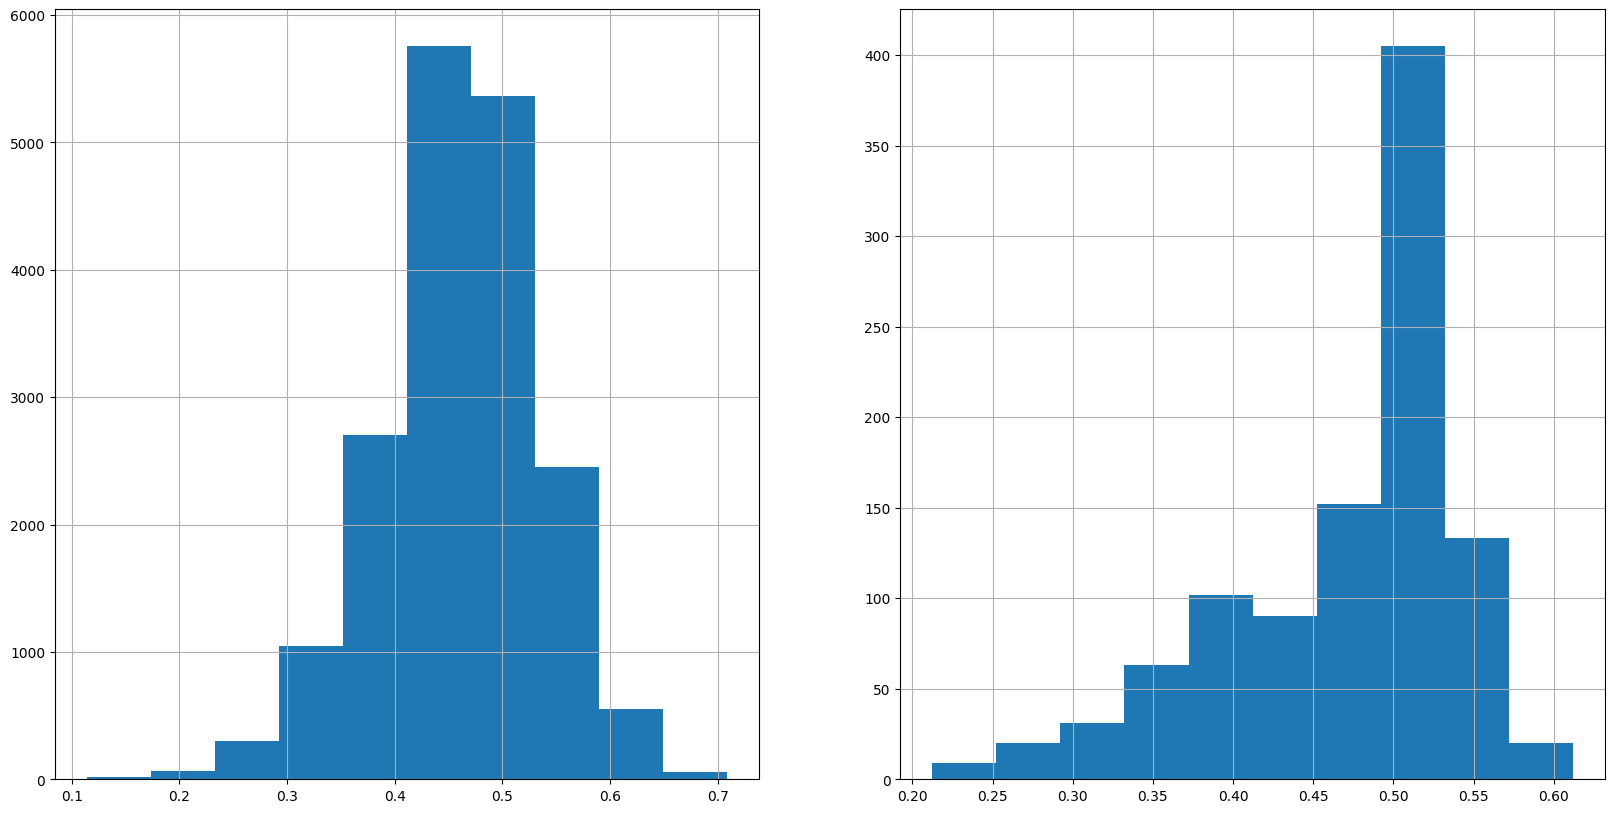

In [123]:
# Weight vector
anc_scan = anchor_rec.laser_readings['scan'].squeeze()
w = np.zeros(anc_scan.shape[0])
# In FOV readings (consider only them for binary masking)
w[64:164] += 1 
# Out of FOV readings (consider also them for soft masking)
x = np.linspace(0.0, 1.0, w[164:].shape[0])
sigmoid = 1 - 0.9*(1 / (1+np.exp(-x))) # Sigmoid 1.0 -> 0.1
w[164:] += sigmoid
w[63::-1] += sigmoid

# Normalizer
den = np.sqrt(w.sum())

# Normalized weighted Eucledian distances on LiDAR readings 
pos_l2_dist = pos_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)
neg_l2_dist = neg_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_l2_dist.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_l2_dist.hist(ax=bx);

In [124]:
np.where(w == 1)[0].shape

(100,)

-5 -5


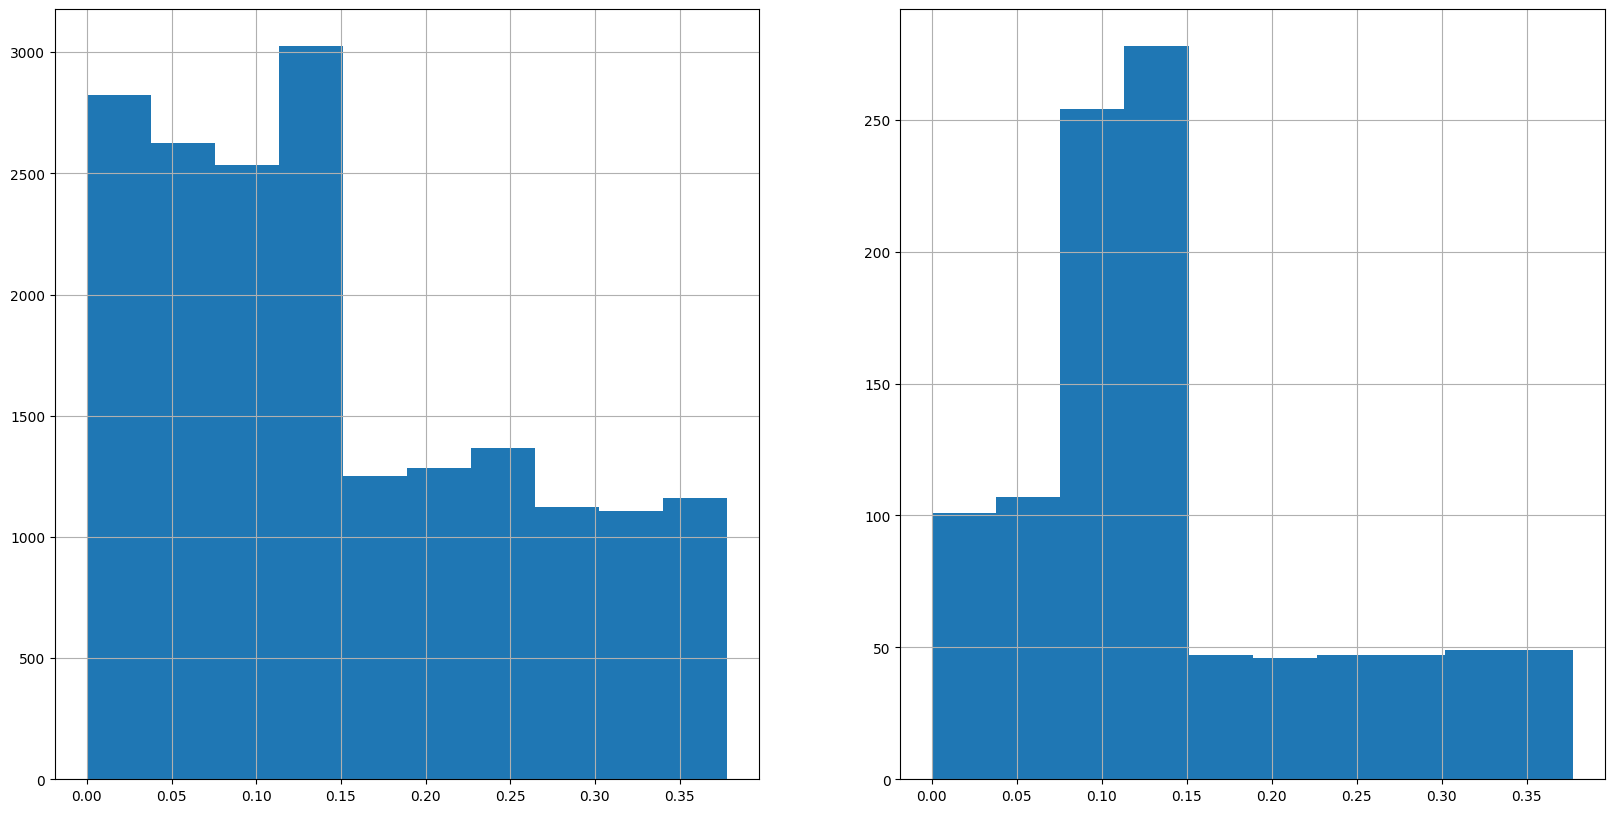

In [125]:
def opposite_corner(x, y):
    opposite_x = -5 if x >= 0 else 5
    opposite_y = -5 if y >= 0 else 5
    return opposite_x, opposite_y

# Normalized goal distance difference 
goal_pos_x, goal_pos_y = anchor_rec['target_point_x'], anchor_rec['target_point_y']
corner_x, corner_y = opposite_corner(goal_pos_x, goal_pos_y)
print(corner_x, corner_y)
max_gd = np.sqrt((goal_pos_x - corner_x)**2 + (goal_pos_y - corner_y)**2)

anchor_gd = np.sqrt((anchor_rec['robot_pos_x'] - goal_pos_x)**2 + (anchor_rec['robot_pos_y'] - goal_pos_y)**2)
pos_gd_diffs = pos_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd 
neg_gd_diffs = neg_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_gd_diffs.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_gd_diffs.hist(ax=bx);

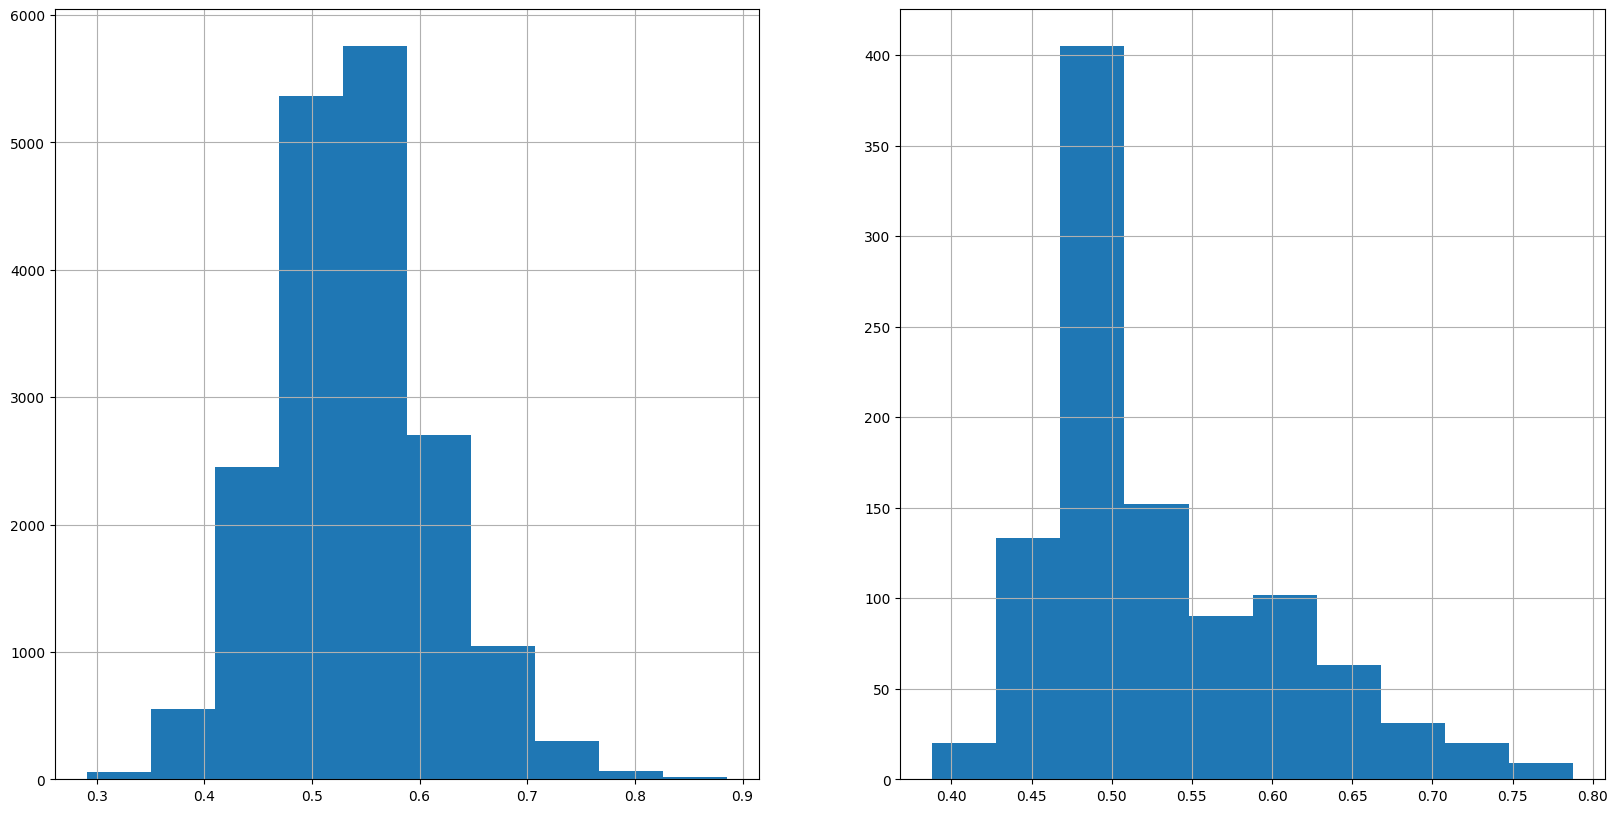

In [126]:
# Combine distances for computing similarities
pos_sim_scores = (1 - pos_l2_dist) #*(1 - pos_gd_diffs)
neg_sim_scores = (1 - neg_l2_dist) #*(1 - neg_gd_diffs)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_sim_scores.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_sim_scores.hist(ax=bx);

In [127]:
# Negative examples mining
BASE_NEG_DIST = 0.4
N_NEG_SAMPLES = 12

negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]
while negative.shape[0] < N_NEG_SAMPLES*2:
    BASE_NEG_DIST += 0.05
    negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]

neg_ex = negative.sample(n=N_NEG_SAMPLES)
neg_ex

14766    0.440372
14090    0.431517
13981    0.427971
14100    0.447210
14096    0.436646
14749    0.396809
14301    0.436814
14880    0.443991
14743    0.424562
14201    0.443859
14873    0.427638
14296    0.437922
Name: laser_readings, dtype: float64

In [128]:
negative_rec = ep_dfs.iloc[neg_ex.index]
negative_rec

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
14766,2,5,8,90,2.5,0.0,1.568974,-0.119263,-0.390757,-0.643037,...,1.405527,4.187955,False,-3.016221,-1.941222,False,"{'scan': [[0.1206803], [0.11767796], [0.114852...",9.0,10.0,11.0
14090,2,5,3,96,2.5,0.0,1.302407,0.528727,-0.426573,-5.229741,...,-1.325324,-2.445805,False,2.854720,-0.675208,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13981,2,5,2,86,2.5,0.0,1.510170,0.432663,-0.356820,-2.563543,...,-0.863443,3.488039,False,-0.744433,3.141569,False,"{'scan': [[0.27724287], [0.27100298], [0.26484...",9.0,10.0,11.0
14100,2,5,3,106,2.5,0.0,1.762531,0.289762,-0.570314,-5.731540,...,-1.507773,-2.698064,False,2.504426,-0.261810,True,"{'scan': [[1.0], [1.0], [0.30302736], [0.29314...",9.0,10.0,11.0
14096,2,5,3,102,2.5,0.0,1.584343,0.393321,-0.481864,-5.431563,...,-1.482134,-2.704104,False,2.614221,-0.528674,True,"{'scan': [[1.0], [1.0], [1.0], [0.2883496], [0...",9.0,10.0,11.0
14749,2,5,8,73,2.5,0.0,0.750528,0.219857,-0.306289,0.551376,...,2.587582,4.358096,False,-2.459781,-1.630760,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
14301,2,5,5,87,2.5,0.0,1.513773,0.280507,-0.407399,-0.679375,...,-1.363774,3.389622,False,-3.922825,1.742289,False,"{'scan': [[0.24893934], [0.24270946], [0.23685...",9.0,10.0,11.0
14880,2,5,9,100,2.5,0.0,1.841862,0.479922,-0.484745,-7.734513,...,1.576370,-2.308920,False,0.641239,-3.924758,False,"{'scan': [[1.0], [0.33483657], [0.32546318], [...",9.0,10.0,11.0
14743,2,5,8,67,2.5,0.0,0.449411,0.305410,-0.257165,1.019816,...,3.137590,4.179489,True,-2.213168,-1.458756,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
14201,2,5,4,93,2.5,0.0,1.759682,0.629910,-0.268254,-5.060062,...,-3.168164,0.939638,False,1.703314,2.243397,True,"{'scan': [[0.30282998], [0.29713976], [0.29175...",9.0,10.0,11.0


In [129]:
# Retrieve negative records
neg_imgs = []
for _, neg_rec in negative_rec.iterrows():
    neg_room = neg_rec['room']
    neg_set = neg_rec['setting']
    neg_ep = neg_rec['episode']
    neg_step = neg_rec['step']
    neg_imgs.append((f'./datasets/with-augmentations/Room{neg_room}/Setting{neg_set}/episode_{neg_ep:04}/rgb_{neg_step:05}.png', neg_room, neg_set, neg_ep, neg_step))

In [130]:
# Positive examples mining
BASE_POS_DIST = 0.9
N_POS_SAMPLES = 4

positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]
while positive.shape[0] < N_POS_SAMPLES*2:
    BASE_POS_DIST -= 0.001
    positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]

pos_ex = positive.sample(n=N_POS_SAMPLES)
pos_ex

16527    0.877360
13049    0.868400
13050    0.875245
13483    0.856785
Name: laser_readings, dtype: float64

In [131]:
positive_rec = ep_dfs.iloc[pos_ex.index]
positive_rec

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
16527,2,7,6,38,2.5,0.0,-1.202210,0.911714,0.273016,-2.228708,...,-2.901764,-4.633094,False,4.495401,-8.047918,False,"{'scan': [[0.09782483], [0.09734136], [0.09689...",9.0,10.0,11.0
13049,2,4,3,36,2.5,0.0,-1.187644,0.941671,0.248912,6.657841,...,-3.666656,-1.868734,False,-4.137378,-1.516667,False,"{'scan': [[0.11711136], [0.116482645], [0.1159...",9.0,10.0,11.0
13050,2,4,3,37,2.5,0.0,-1.138033,0.953611,0.219028,6.558828,...,-3.644567,-1.984947,False,-4.136876,-1.594304,False,"{'scan': [[0.1200451], [0.119329244], [0.11866...",9.0,10.0,11.0
13483,2,4,7,40,2.5,0.0,-1.088516,0.960427,0.223755,0.950243,...,-3.042795,-4.367620,False,2.630122,-6.266940,False,"{'scan': [[0.12132268], [0.12061049], [0.11994...",9.0,10.0,11.0


In [132]:
# Retrieve positive records
pos_imgs = []
for _, pos_rec in positive_rec.iterrows():
    pos_room = pos_rec['room']
    pos_set = pos_rec['setting']
    pos_ep = pos_rec['episode']
    pos_step = pos_rec['step']
    pos_imgs.append((f'./datasets/with-augmentations/Room{pos_room}/Setting{pos_set}/episode_{pos_ep:04}/rgb_{pos_step:05}.png', pos_room, pos_set, pos_ep, pos_step))

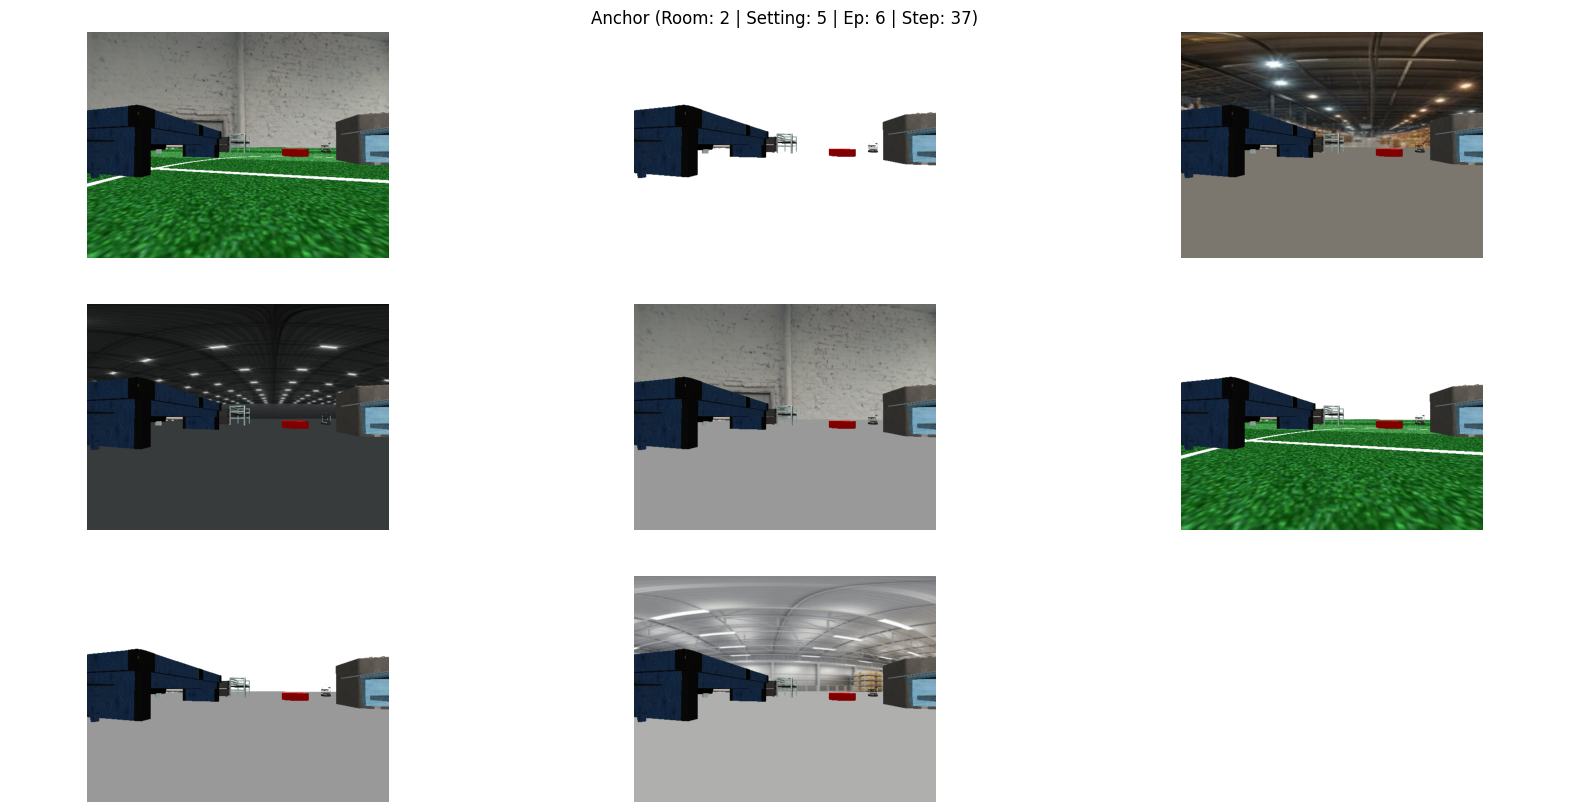

In [133]:
# Anchor image
anc_img = Image.open(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/rgb_{step:05}.png')
# Augmentations
aug_paths = glob(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/augmented_results/*_rgb_{step:05}.png')

# Plot
ROWS = 3
COLS = 3
plt.figure(figsize=[20,10])
plt.title(f'Anchor (Room: {room} | Setting: {setting} | Ep: {ep} | Step: {step})')
plt.axis('off')
plt.subplot(ROWS, COLS, 1)
plt.axis('off')
plt.imshow(anc_img)
for idx, path in enumerate(aug_paths):
    img = Image.open(path)
    plt.subplot(ROWS, COLS, idx+2)
    plt.axis('off')
    plt.imshow(img)

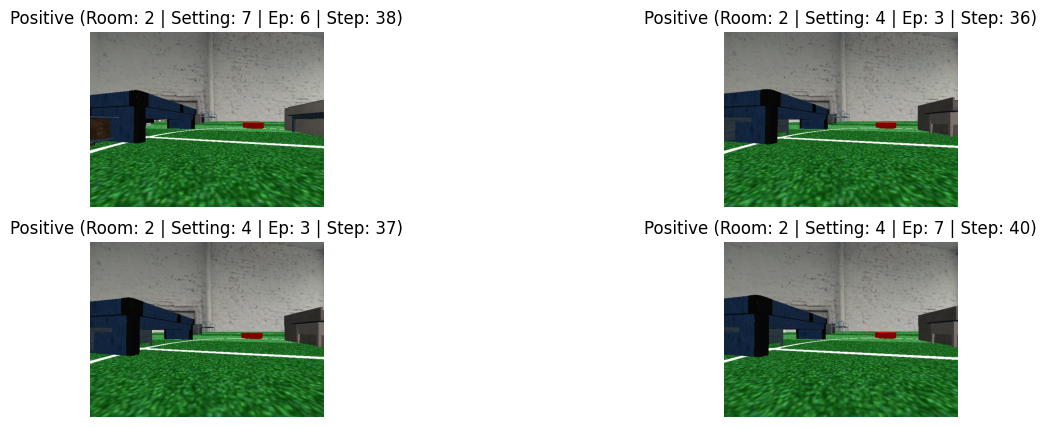

In [134]:
N_ROWS = 2
N_COLS = 2

# Plot positive examples by similarity
plt.figure(figsize=[15,5])
for idx, pos in enumerate(pos_imgs):
    img = Image.open(pos[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Positive (Room: {pos[1]} | Setting: {pos[2]} | Ep: {pos[3]} | Step: {pos[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();

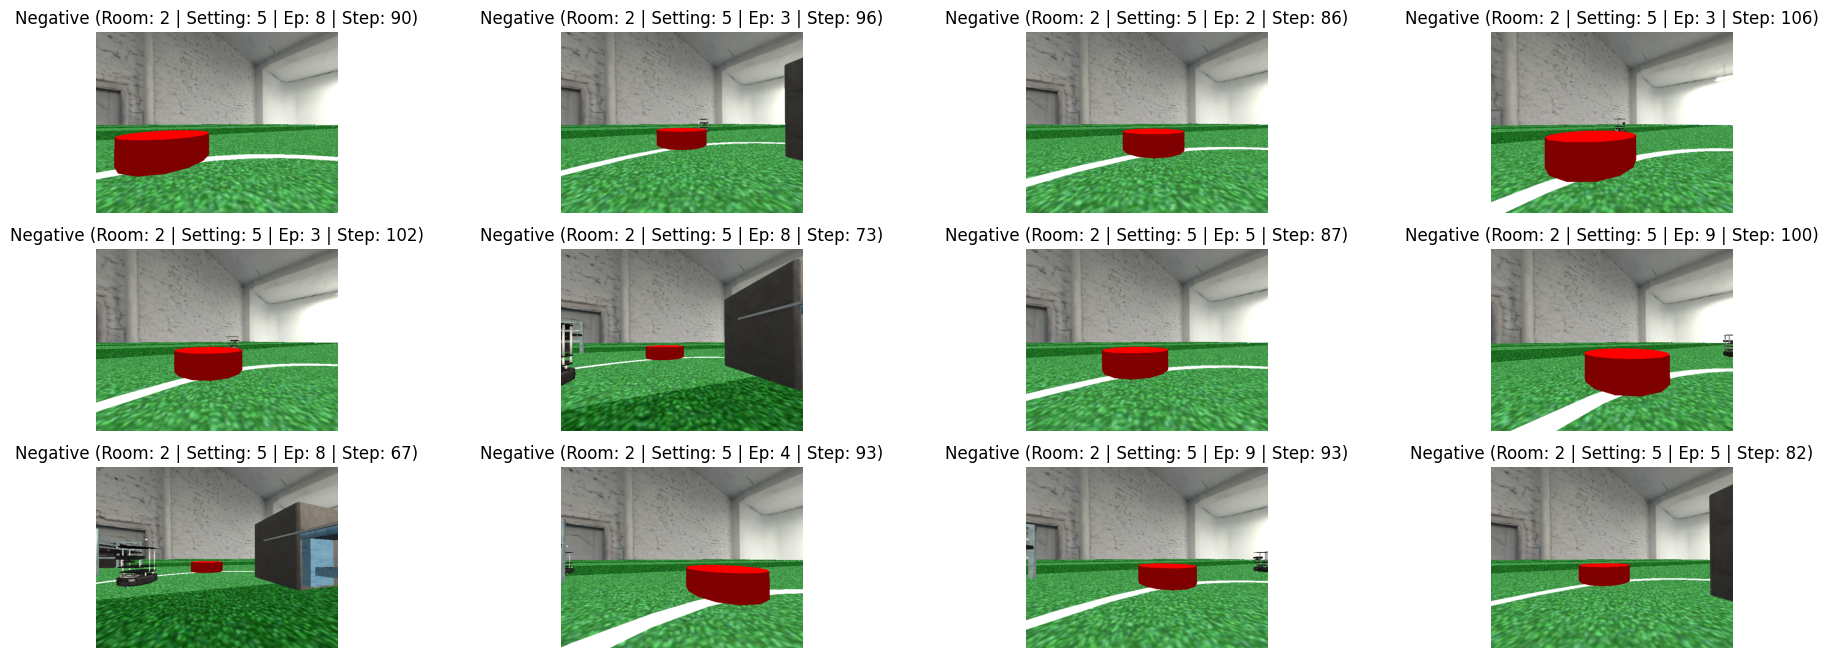

In [135]:
N_ROWS = 3
N_COLS = 4

# Plot negative examples by similarity
plt.figure(figsize=[23,8])
for idx, neg in enumerate(neg_imgs):
    img = Image.open(neg[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Negative (Room: {neg[1]} | Setting: {neg[2]} | Ep: {neg[3]} | Step: {neg[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();